In [ ]:
"""
- This notebook compares multiple models to identify the best approach for customer churn prediction.
- The models analyzed are 
   1. A logistic regression model
   2. A random forest model
   3. XGboost (Extreme Gradient Boosting)

- Model performance is evaluated using three metrics:
    1. **ROC-AUC** – measures the model’s ability to separate churners from non-churners, independent of categorization threshold.
    2. **Weighted F1-score** – calculated at an optimal classification threshold that balances precision and recall, 
       which is especially important for imbalanced datasets where catching churners (recall) and avoiding false alarms (precision) are both important.
    3. **Minimized weighted cost** – quantifies the business impact of misclassifications, with false negatives (missed churners) considered 
       five times more costly than false positives, reflecting real-world priorities.

- The optimal threshold for classification is chosen by minimizing this weighted cost, ensuring that model performance is aligned with business objectives.
"""

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import roc_curve, confusion_matrix, classification_report, roc_auc_score, f1_score

from joblib import dump
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [56]:
# Load processed data.

# --- Paths ---
project_root = Path("../")
processed_dir = project_root / "data" / "processed"
model_dir = project_root / "models"

# Loading training and testing datasets
X_train = np.load(processed_dir / "X_train.npy")
y_train = np.load(processed_dir / "y_train.npy")
X_test = np.load(processed_dir / "X_test.npy")
y_test = np.load(processed_dir / "y_test.npy")


In [ ]:

"""
In this cell we define function compute_optimal_f1_score, which is used to compute the metrics
that are used to quantify the models performance.
"""

def compute_model_performance_metrics(y_test, y_proba):
    """
    Compute the optimal classification threshold for a model and quantify its performance.

    This function calculates:
    1. The optimal classification threshold that minimizes a weighted cost of false negatives and false positives.
       - False negatives are considered 5 times more costly than false positives by default.
    2. The minimum weighted cost at this threshold.
    3. The weighted F1-score at this threshold, which balances precision and recall 
       and accounts for class imbalance.
    4. The ROC-AUC score, which measures the model's ability to separate classes independent of threshold.

    Parameters
    ----------
    y_test : array-like
        True labels (0/1) for the test set.
    y_proba : array-like
        Predicted probabilities for the positive class.

    Returns
    -------
    optimal_threshold_weighted : float
        The classification threshold that minimizes the weighted cost.
    min_weighted_cost : int
        The minimum weighted cost achieved at the optimal threshold.
    f1_weighted : float
        The weighted F1-score at the optimal threshold.
    roc_auc : float
        ROC-AUC score, threshold-independent measure of model discrimination.
    cm : ndarray of shape (2, 2)
        Confusion matrix at the optimal threshold.
    cr : str
        Text-based classification report at the optimal threshold.
    fpr : array
        False positive rates for all thresholds (for ROC curve plotting).
    tpr : array
        True positive rates for all thresholds (for ROC curve plotting).
    """
    
    # Compute ROC-AUC
    roc_auc = roc_auc_score(y_test, y_proba)
    
    # Get thresholds from ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)

    # Define weights for business costs
    fn_weight, fp_weight = 5, 1
    costs = []
    
    # Compute weighted cost for each threshold
    for t in thresholds:
        y_pred_t = (y_proba >= t).astype(int)
        _, fp, fn, _ = confusion_matrix(y_test, y_pred_t).ravel()
        weighted_cost = fn_weight * fn + fp_weight * fp
        costs.append(weighted_cost)

    # Find threshold that minimizes weighted cost
    optimal_idx = np.argmin(costs)
    optimal_threshold = thresholds[optimal_idx]

    # Find minimum cost
    min_weighted_cost = min(costs)

    # Compute weighted F1-score at optimal threshold
    y_pred_opt = (y_proba >= optimal_threshold).astype(int)
    f1_weighted = f1_score(y_test, y_pred_opt, average='weighted')

    # Compute confusion matrix and classification report with the optimized threshold
    cm = confusion_matrix(y_test, y_pred_opt)
    cr = classification_report(y_test, y_pred_opt)
    
    return optimal_threshold, min_weighted_cost, f1_weighted, roc_auc, cm, cr, fpr, tpr


In [58]:
# In this cell we define the three models

# Logistic regression
logreg = LogisticRegression(
    max_iter=1000,
    random_state=42)

# Random Forest
rf = RandomForestClassifier(
    n_estimators=200,        # number of trees
    max_depth=None,          # grow until all leaves are pure or min_samples_leaf reached
    random_state=42,
    n_jobs=-1                # use all cores
)

# XGBoost
xgb_clf = xgb.XGBClassifier(
    n_estimators=200,      # number of trees
    max_depth=5,           # maximum depth of each tree
    learning_rate=0.1,     # step size shrinkage
    subsample=0.8,         # fraction of samples for each tree
    colsample_bytree=0.8,  # fraction of features for each tree
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Save the models to models dictionary
models = {'Logistic Regression': logreg, 
          'Random Forest': rf,
          'XGBoost': xgb_clf}



In [59]:
# In this cell the models are trained and probabilities for churn predicted

results = {}

for model_name, model in models.items():

    model.fit(X_train, y_train)
    dump(model, model_dir / f"{model_name.replace(' ', '_').lower()}_model.joblib") # Saving the trained model
    y_proba = model.predict_proba(X_test)[:,1]
    res = compute_model_performance_metrics(y_test, y_proba)
    results[model_name] = res



c:\Users\lauri\Documents\ChurnPrediction\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [20:49:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [64]:
# In this cell we summarize and visualize the results.

summary = pd.DataFrame({
    'Model': [],
    'ROC-AUC': [],
    'Optimal Threshold': [],
    'Weighted F1-score': [],
    'Minimized Cost': []
})

for model_name, res in results.items():
    optimal_threshold, min_cost, f1_weighted, roc_auc, _, _, _, _ = res
    summary = pd.concat([summary, pd.DataFrame({
        'Model': [model_name],
        'ROC-AUC': [roc_auc],
        'Optimal Threshold': [optimal_threshold],
        'Weighted F1-score': [f1_weighted],
        'Minimized Cost': [min_cost]
    })], ignore_index=True)

# Set Model as index
summary.set_index('Model', inplace=True)

# Display summary table
display(summary)



,ROC-AUC,Optimal Threshold,Weighted F1-score,Minimized Cost
Model,,,,
Logistic Regression,0.835929,0.156862,0.672693,622.0
Random Forest,0.813999,0.180000,0.681151,659.0
XGBoost,0.820137,0.086675,0.641488,657.0


C:\Users\lauri\AppData\Local\Temp\ipykernel_36908\4105871189.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(summary.index, rotation=30, ha='right')
C:\Users\lauri\AppData\Local\Temp\ipykernel_36908\4105871189.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(summary.index, rotation=30, ha='right')
C:\Users\lauri\AppData\Local\Temp\ipykernel_36908\4105871189.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(summary.index, rotation=30, ha='right')
C:\Users\lauri\AppData\Local\Temp\ipykernel_36908\4105871189.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[3].set_xtic

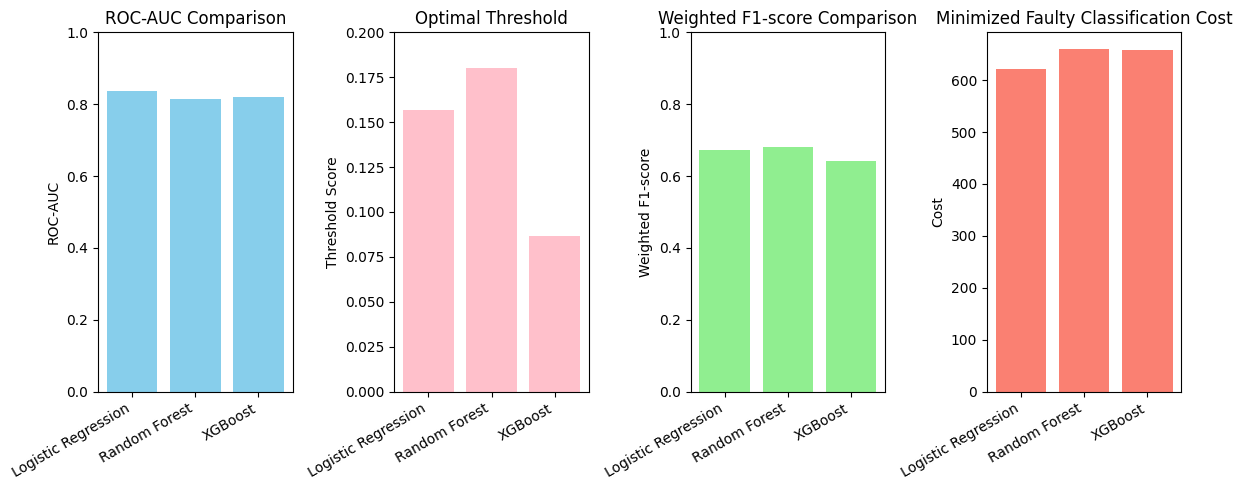

In [68]:
# ~ Results visualization ~

fig, axes = plt.subplots(1, 4, figsize=(12,5))

# ROC-AUC
axes[0].bar(summary.index, summary['ROC-AUC'], color='skyblue')
axes[0].set_title('ROC-AUC Comparison')
axes[0].set_ylim(0,1)
axes[0].set_ylabel('ROC-AUC')
axes[0].set_xticklabels(summary.index, rotation=30, ha='right')

# Weighted F1-score
axes[1].bar(summary.index, summary['Optimal Threshold'], color='pink')
axes[1].set_title('Optimal Threshold')
axes[1].set_ylim(0,0.2)
axes[1].set_ylabel('Threshold Score')
axes[1].set_xticklabels(summary.index, rotation=30, ha='right')

# Weighted F1-score
axes[2].bar(summary.index, summary['Weighted F1-score'], color='lightgreen')
axes[2].set_title('Weighted F1-score Comparison')
axes[2].set_ylim(0,1)
axes[2].set_ylabel('Weighted F1-score')
axes[2].set_xticklabels(summary.index, rotation=30, ha='right')

# Minimized Cost
axes[3].bar(summary.index, summary['Minimized Cost'], color='salmon')
axes[3].set_title('Minimized Faulty Classification Cost')
axes[3].set_ylabel('Cost')
axes[3].set_xticklabels(summary.index, rotation=30, ha='right')

plt.tight_layout()
plt.show()

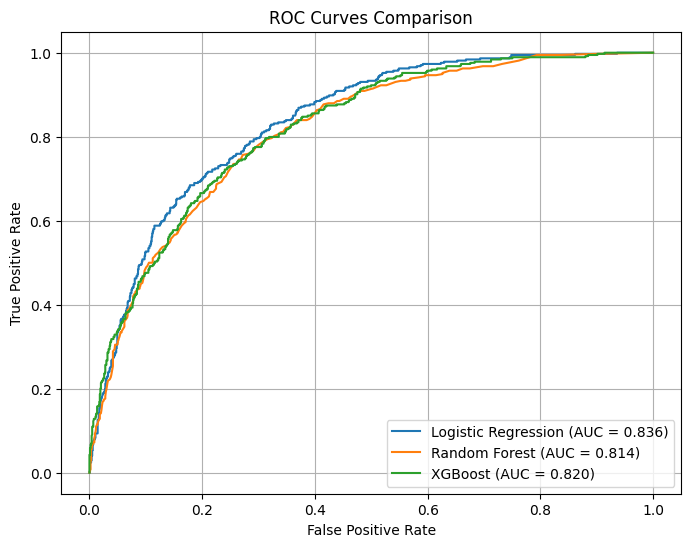

In [62]:
# -----------------------------
# Plot all ROC curves on the same figure
# -----------------------------
plt.figure(figsize=(8,6))

for model_name, res in results.items():
    _, _, _, roc_auc, _, _, fpr, tpr = res
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# CONCLUSIONS

"""
It’s interesting to see that Logistic Regression performs really well, even slightly better
than Random Forest and XGBoost in terms of ROC-AUC and minimizing business cost. I think
this makes sense because a lot of the features, like tenure, monthly charges, and contract type,
have fairly straightforward relationships with churn, which fits well with a linear model.

Also, Logistic Regression gives well-calibrated probabilities, which helps when picking an
optimal threshold based on business cost. For this dataset, it seems that a simpler,
model can do just as well or even better than more complex models. That’s great for making
the results easy to explain and deploy in a real-world scenario.
"""


'\nIt’s interesting to see that Logistic Regression performs really well, even slightly better\nthan Random Forest and XGBoost in terms of ROC-AUC and minimizing business cost. I think\nthis makes sense because a lot of the features, like tenure, monthly charges, and contract type,\nhave fairly straightforward relationships with churn, which fits well with a linear model.\n\nAlso, Logistic Regression gives well-calibrated probabilities, which helps when picking an\noptimal threshold based on business cost. For this dataset, it seems that a simpler, interpretable\nmodel can do just as well—or even better—than more complex models. That’s great for making\nthe results easy to explain and deploy in a real-world scenario.\n'